# Preparation 
## Append to path and import
In case gumpy is not installed as package, you may have to specify the path to the gumpy directory

In [1]:
%reset
%matplotlib inline

import sys, os, os.path
sys.path.append('../../../gumpy')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
## import gumpy
This may take a while, as gumpy as several dependencies that will be loaded automatically

In [2]:
import numpy as np
import gumpy

# Import data
To import data, you have to specify the directory in which your data is stored in. For the example given here, the data is in the subfolder ``../EEG-Data/Graz_data/data``. 
Then, one of the classes that subclass from ``dataset`` can be used to load the data. In the example, we will use the GrazB dataset, for which ``gumpy`` already includes a corresponding class. If you have different data, simply subclass from ``gumpy.dataset.Dataset``.

In [3]:

# First specify the location of the data and some 
# identifier that is exposed by the dataset (e.g. subject)

data_base_dir = '../../../Data'

grazb_base_dir = os.path.join(data_base_dir, 'Graz')
subject = 'B01'

# The next line first initializes the data structure. 
# Note that this does not yet load the data! In custom implementations
# of a dataset, this should be used to prepare file transfers, 
# for instance check if all files are available, etc.
grazb_data = gumpy.data.GrazB(grazb_base_dir, subject)

# Finally, load the dataset
grazb_data.load()


The abstract class allows to print some information about the contained data. This is a commodity function that allows quick inspection of the data as long as all necessary fields are provided in the subclassed variant.

In [4]:
grazb_data.print_stats()

Data identification: GrazB-B01
EEG-data shape: (1626266, 3)
Trials data shape:  (324,)
Labels shape:  (324,)
Total length of single trial:  8
Sampling frequency of EEG data: 250
Interval for motor imagery in trial:  [4, 7]
Classes possible:  [0 1]


# Postprocess data
Usually it is necessary to postprocess the raw data before you can properly use it. ``gumpy`` provides several methods to easily do so, or provides implementations that can be adapted to your needs.

Most methods internally use other Python toolkits, for instance ``sklearn``, which is heavily used throughout ``gumpy``. Thereby, it is easy to extend ``gumpy`` with custom filters. In addition, we expect users to have to manipulate the raw data directly as shown in the following example.

## Common average re-referencing the data  to Cz
Some data is required to be re-referenced to a certain electrode. Because this may depend on your dataset, there is no common function provided by ``gumpy`` to do so. However and if sub-classed according to the documentation, you can access the raw-data directly as in the following example.

In [79]:
if 0:
    grazb_data.raw_data[:, 0] -= 2 * grazb_data.raw_data[:, 1]
    grazb_data.raw_data[:, 2] -= 2 * grazb_data.raw_data[:, 2]

## Example: Notch and Band-Pass Filters
``gumpy`` ships with several filters already implemented. They accept either raw data to be filtered, or a subclass of ``Dataset``. In the latter case, ``gumpy`` will automatically convert all channels using parameters extracted from the dataset.

In [5]:
# this returns a butter-bandpass filtered version of the entire dataset
btr_data = gumpy.signal.butter_bandpass(grazb_data, lo=0.5, hi=30)

# it is also possible to use filters on individual electrodes using 
# the .raw_data field of a dataset. The example here will remove a certain
# from a single electrode using a Notch filter. This example also demonstrates
# that parameters will be forwarded to the internal call to the filter, in this
# case the scipy implementation iirnotch (Note that iirnotch is only available
# in recent versions of scipy, and thus disabled in this example by default)

# frequency to be removed from the signal
if False:
    f0 = 50.0 
    # quality factor
    Q = 50.0  
    # get the cutoff frequency
    w0 = f0/(grazb_data.sampling_freq/2) 
    # apply the notch filter
    btr_data = gumpy.signal.notch(btr_data[:, 0], w0, Q)

## Normalization
Many datasets require normalization. ``gumpy`` provides functions to compute normalization either using a mean computation or via min/max computation. As with the filters, this function accepts either an instance of ``Dataset``, or raw_data. In fact, it can be used for postprocessing any row-wise data in a numpy matrix.

In [ ]:
# # normalize the data first
# norm_data = gumpy.signal.normalize(grazb_data, 'mean_std')
# # let's see some statistics
# print("""Normalized Data:
#   Mean    = {:.3f}
#   Min     = {:.3f}
#   Max     = {:.3f}
#   Std.Dev = {:.3f}""".format(
#   np.nanmean(norm_data),np.nanmin(norm_data),np.nanmax(norm_data),np.nanstd(norm_data)
# ))

# Plotting and Feature Extraction

Certainly you wish to plot results. ``gumpy`` provides several functions that show how to implement visualizations. For this purpose it heavily relies on ``matplotlib``, ``pandas``, and ``seaborn``. The following examples will show several of the implemented signal processing methods as well as their corresponding plotting functions. Moreover, the examples will show you how to extract features

That said, let's start with a simple visualization where we access the filtered data from above to show you how to access the data and plot it.

Text(0.5,1,' Filtered Data')

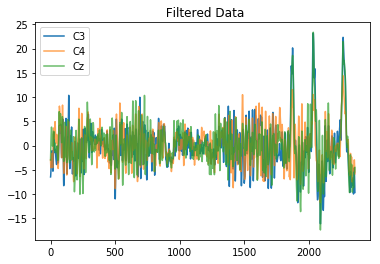

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt 

# Plot after filtering with a butter bandpass (ignore normalization)
plt.figure()
plt.clf()
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 0], label='C3')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 1], alpha=0.7, label='C4')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 2], alpha=0.7, label='Cz')
plt.legend()
plt.title(" Filtered Data")

## EEG band visualization
Using ``gumpy``'s filters and the provided method, it is easy to filter and subsequently plot the  EEG bands of a trial.

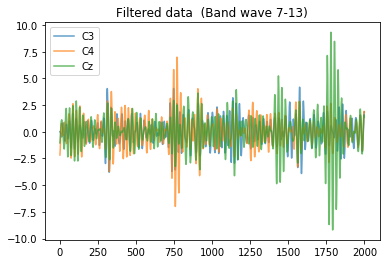

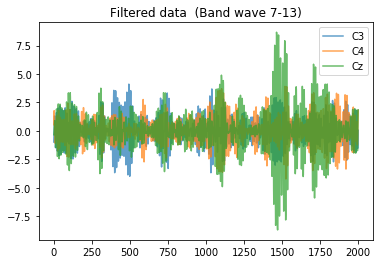

In [7]:
# determine the trial that we wish to plot
n_trial = 120
# now specify the alpha and beta cutoff frequencies
lo_a, lo_b = 7, 16
hi_a, hi_b = 13, 24

# first step is to filter the data
flt_a = gumpy.signal.butter_bandpass(grazb_data, lo=lo_a, hi=hi_a)
flt_b = gumpy.signal.butter_bandpass(grazb_data, lo=lo_b, hi=hi_b)

# finally we can visualize the data
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_a, n_trial, lo_a, hi_a)
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_b, n_trial, lo_a, hi_a)

## Extract trials
Now we wish to extract the trials from the data. This operation may heavily depend on your dataset, and thus we cannot guarantee that the function works for your specific dataset. However, the used function ``gumpy.utils.extract_trials`` can be used as a guideline how to extract the trials you wish to examine.

In [97]:
# retrieve the trials from the filtered data. This requires that the function
# knows the number of trials, labels, etc. when only passed a (filtered) data matrix
trials = grazb_data.trials
labels = grazb_data.labels
sampling_freq = grazb_data.sampling_freq
data_class_a = gumpy.utils.extract_trials(flt_a, trials=trials, labels=labels, sampling_freq=sampling_freq)

# it is also possible to pass an instance of Dataset and filtered data.
# gumpy will then infer all necessary details from the dataset
data_class_b = gumpy.utils.extract_trials(grazb_data, flt_b)

# similar to other functions, this one allows to pass an entire instance of Dataset
# to operate on the raw data
data_class1 = gumpy.utils.extract_trials(grazb_data)
np.array(data_class1[1]).shape 

(157, 2000)

## Visualize the classes
Given the extracted trials from above, we can proceed to visualize the average power of a class. Again, this depends on the specific data and thus you may have to adapt the function accordingly.

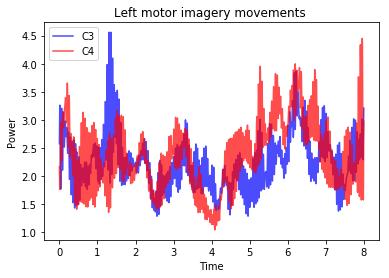

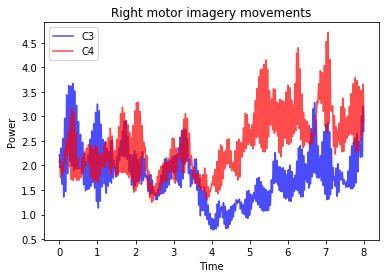

In [98]:
# specify some cutoff values for the visualization
lowcut_a, highcut_a = 14, 30
# and also an interval to display
interval_a = [0, 8]
# visualize logarithmic power?
logarithmic_power = False

# visualize the extracted trial from above
gumpy.plot.average_power(data_class_a, lowcut_a, highcut_a, interval_a, grazb_data.sampling_freq, logarithmic_power)

## Wavelet transform
``gumpy`` relies on ``pywt`` to compute wavelet transforms. Furthermore, it contains convenience functions to visualize the results of the discrete wavelet transform as shown in the example below for the Graz dataset and the classes extracted above.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe288ca5c0>,
      dtype=object)

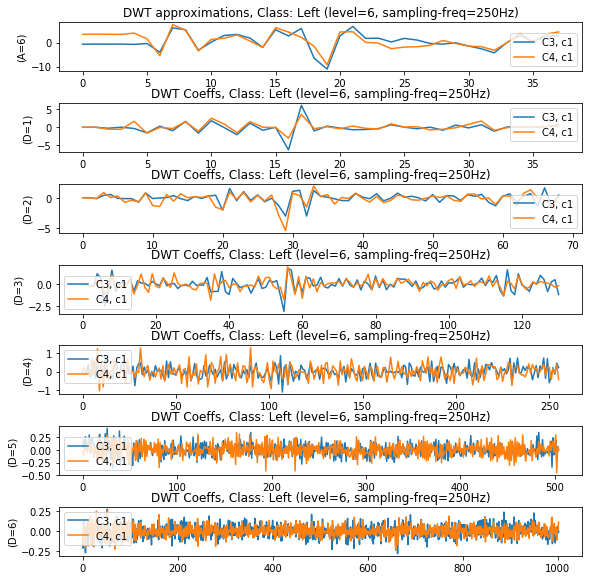

In [11]:
# As with most functions, you can pass arguments to a 
# gumpy function that will be forwarded to the backend.
# In this example the decomposition levels are mandatory, and the 
# mother wavelet that should be passed is optional
level = 6
wavelet = 'db4'

# now we can retrieve the dwt for the different channels
mean_coeff_ch0_c1 = gumpy.signal.dwt(data_class1[0], level=level, wavelet=wavelet)
mean_coeff_ch1_c1 = gumpy.signal.dwt(data_class1[1], level=level, wavelet=wavelet)
mean_coeff_ch0_c2 = gumpy.signal.dwt(data_class1[3], level=level, wavelet=wavelet)
mean_coeff_ch1_c2 = gumpy.signal.dwt(data_class1[4], level=level, wavelet=wavelet)

# gumpy's signal.dwt function returns the approximation of the 
# coefficients as first result, and all the coefficient details as list
# as second return value (this is contrast to the backend, which returns
# the entire set of coefficients as a single list)
approximation_C3 = mean_coeff_ch0_c2[0]
approximation_C4 = mean_coeff_ch1_c2[0]

# as mentioned in the comment above, the list of details are in the second
# return value of gumpy.signal.dwt. Here we save them to additional variables
# to improve clarity
details_c3_c1 = mean_coeff_ch0_c1[1]
details_c4_c1 = mean_coeff_ch1_c1[1]
details_c3_c2 = mean_coeff_ch0_c2[1]
details_c4_c2 = mean_coeff_ch1_c2[1]

# gumpy exhibits a function to plot the dwt results. You must pass three lists,
# i.e. the labels of the data, the approximations, as well as the detailed coeffs,
# so that gumpy can automatically generate appropriate titles and labels.
# you can pass an additional class string that will be incorporated into the title.
# the function returns a matplotlib axis object in case you want to further
# customize the plot.
gumpy.plot.dwt(
    [approximation_C3, approximation_C4],
    [details_c3_c1, details_c4_c1],
    ['C3, c1', 'C4, c1'],
    level, grazb_data.sampling_freq, 'Class: Left')


## DWT reconstruction and visualization
Often a user wantes to reconstruct the power spectrum of a dwt and visualize the results. The functions will return a list of all the reconstructed signals as well as a handle to the figure.

In [36]:
gumpy.plot.reconstruct_without_approx(
    [details_c3_c2[4], details_c4_c2[4]], 
    ['C3-c1', 'C4-c1'], level=6)

gumpy.plot.reconstruct_without_approx(
    [details_c3_c1[5], details_c4_c1[5]], 
    ['C3-c1', 'C4-c1'], level=6)

NameError: name 'details_c3_c2' is not defined

([array([-0.04379641,  0.17916636, -0.15634663, ...,  0.05339261,
         -0.05486782,  0.01305731]),
  array([-0.01783179,  0.0415965 , -0.07318729, ...,  0.03480512,
         -0.01006542,  0.00087816])],
 <Figure size 432x288 with 1 Axes>)

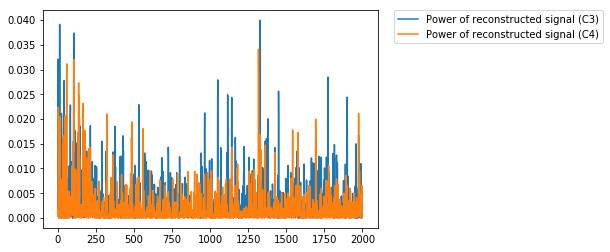

In [13]:
gumpy.plot.reconstruct_with_approx(
    [details_c3_c1[5], details_c4_c1[5]],
    ['C3', 'C4'], wavelet=wavelet)

## Welch's Power Spectral Density estimate
Estimating the power spectral density according to Welch's method is =imilar to the power reconstruction shown above

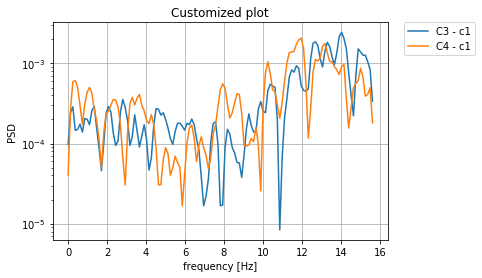

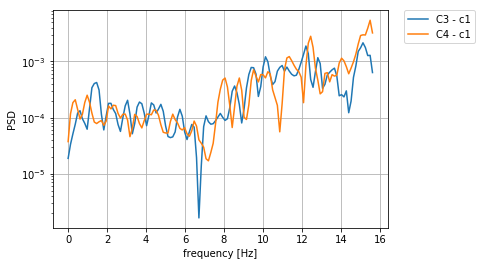

In [14]:
# the function gumpy.plot.welch_psd returns the power densities as 
# well as a handle to the figure. You can also pass a figure in if you 
# wish to modify the plot
fig = plt.figure()
plt.title('Customized plot')
ps, fig = gumpy.plot.welch_psd(
    [details_c3_c1[4], details_c3_c2[4]],
    ['C3 - c1', 'C4 - c1'],
    grazb_data.sampling_freq, fig=fig)

ps, fig = gumpy.plot.welch_psd(
    [details_c4_c1[4], details_c4_c2[4]],
    ['C3 - c1', 'C4 - c1'],
    grazb_data.sampling_freq)

## Alpha and Beta sub-bands
Using gumpys functions you can quickly define feature extractors. The following examples will demonstrate how you can use the predefined filters

In [8]:
def alpha_subBP_features(data):
    # filter data in sub-bands by specification of low- and high-cut frequencies
    alpha1 = gumpy.signal.butter_bandpass(data, 8.5, 11.5, order=6)
    alpha2 = gumpy.signal.butter_bandpass(data, 9.0, 12.5, order=6)
    alpha3 = gumpy.signal.butter_bandpass(data, 9.5, 11.5, order=6)
    alpha4 = gumpy.signal.butter_bandpass(data, 8.0, 10.5, order=6)

    # return a list of sub-bands
    return [alpha1, alpha2, alpha3, alpha4]

alpha_bands = np.array(alpha_subBP_features(btr_data))

In [9]:
def beta_subBP_features(data):
    beta1 = gumpy.signal.butter_bandpass(data, 14.0, 30.0, order=6)
    beta2 = gumpy.signal.butter_bandpass(data, 16.0, 17.0, order=6)
    beta3 = gumpy.signal.butter_bandpass(data, 17.0, 18.0, order=6)
    beta4 = gumpy.signal.butter_bandpass(data, 18.0, 19.0, order=6)
    return [beta1, beta2, beta3, beta4]

beta_bands = np.array(beta_subBP_features(btr_data))

## Feature extraction using sub-bands
The following examples show how the sub-bands can be used to extract features. This also shows how the fields of the dataset can be accessed, and how to write methods specific to your data using a mix of gumpy's and numpy's functions.

### Method 1: logarithmic sub-band power

In [10]:
def powermean(data, trial, fs, w):
    return np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],0],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],1],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],2],2).mean()

def log_subBP_feature_extraction(alpha, beta, trials, fs, w):
    # number of features combined for all trials
    n_features = 15
    # initialize the feature matrix
    X = np.zeros((len(trials), n_features))
    
    # Extract features
    for t, trial in enumerate(trials):
        power_c31, power_c41, power_cz1 = powermean(alpha[0], trial, fs, w)
        power_c32, power_c42, power_cz2 = powermean(alpha[1], trial, fs, w)
        power_c33, power_c43, power_cz3 = powermean(alpha[2], trial, fs, w)
        power_c34, power_c44, power_cz4 = powermean(alpha[3], trial, fs, w)
        power_c31_b, power_c41_b, power_cz1_b = powermean(beta[0], trial, fs, w)
        
        X[t, :] = np.array(
            [np.log(power_c31), np.log(power_c41), np.log(power_cz1),
             np.log(power_c32), np.log(power_c42), np.log(power_cz2),
             np.log(power_c33), np.log(power_c43), np.log(power_cz3), 
             np.log(power_c34), np.log(power_c44), np.log(power_cz4),
             np.log(power_c31_b), np.log(power_c41_b), np.log(power_cz1_b)])

    return X

In [11]:
w1 = [0,125]
w2 = [125,256]
w3 = [256,512]
w4 = [512,512+256]
features1 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w1)

features2 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w2)     
features3 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w3)        
features4 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w4)        

# concatenate the features and normalize the data
features = np.concatenate((features1.T, features2.T,features3.T,features4.T)).T
features -= np.mean(features)
features = gumpy.signal.normalize(features, 'min_max')

# print shape to quickly check if everything is as expected
features.shape

(324, 60)

### Method 2: DWT

In [41]:
def dwt_features(data, trials, level, sampling_freq, w, n, wavelet): 
    import pywt
    
    # number of features per trial
    n_features = 9 
    # allocate memory to store the features
    X = np.zeros((len(trials), n_features))

    # Extract Features
    for t, trial in enumerate(trials):
        signals = data[trial + fs*4 + (w[0]) : trial + fs*4 + (w[1])]
        coeffs_c3 = pywt.wavedec(data = signals[:,0], wavelet=wavelet, level=level)
        coeffs_c4 = pywt.wavedec(data = signals[:,1], wavelet=wavelet, level=level)
        coeffs_cz = pywt.wavedec(data = signals[:,2], wavelet=wavelet, level=level)

        X[t, :] = np.array([
            np.std(coeffs_c3[n]), np.mean(coeffs_c3[n]**2),  
            np.std(coeffs_c4[n]), np.mean(coeffs_c4[n]**2),
            np.std(coeffs_cz[n]), np.mean(coeffs_cz[n]**2), 
            np.mean(coeffs_c3[n]),
            np.mean(coeffs_c4[n]), 
            np.mean(coeffs_cz[n])])
        
    return X

In [42]:
# We'll work with the data that was postprocessed using a butter bandpass
# filter further above

# to see it work, enable here. We'll use the log-power features further
# below, though
if False:
    w = [0, 256]
    
    # extract the features
    trials = grazb_data.trials
    fs = grazb_data.sampling_freq
    features1= np.array(dwt_features(btr_data, trials, 5, fs, w, 3, "db4"))
    features2= np.array(dwt_features(btr_data, trials, 5, fs, w, 4, "db4"))

    # concat the features and normalize
    features = np.concatenate((features1.T, features2.T)).T
    features -= np.mean(features)
    features = gumpy.signal.normalize(features, 'min_max')

## Sequential Feature Selection Algorithm
``gumpy`` provides a generic function with which you can select features. For a list of the implemented selectors please have a look at the function documentation.


LDA


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished

[2018-04-02 20:09:15] Features: 1/20 -- score: 0.6403769841269842[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-04-02 20:09:16] Features: 2/20 -- score: 0.7101686507936508[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-04-02 20:09:16] Features: 3/20 -- score: 0.7353174603174603[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2018-04-02 20:09:17] Features: 4/20 -- score: 0.754365079365

[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2018-04-02 20:09:31] Features: 18/20 -- score: 0.7985615079365079[Parallel(n_jobs=-1)]: Done   5 out of  42 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2018-04-02 20:09:32] Features: 19/20 -- score: 0.7985615079365079[Parallel(n_jobs=-1)]: Done   5 out of  41 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_job

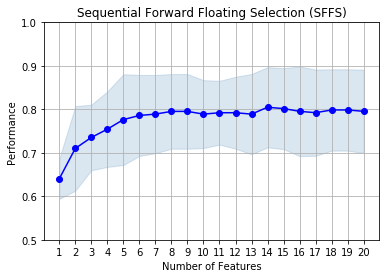

{'LDA': 80.48115079365078}
LogisticRegression


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished

[2018-04-02 20:09:33] Features: 1/20 -- score: 0.6403769841269842[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-04-02 20:09:34] Features: 2/20 -- score: 0.7069940476190476[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-04-02 20:09:34] Features: 3/20 -- score: 0.7290178571428572[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed

[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2018-04-02 20:09:48] Features: 17/20 -- score: 0.805059523809524[Parallel(n_jobs=-1)]: Done   6 out of  43 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished

[2018-04-02 20:09:49] Features: 16/20 -- score: 0.8114087301587303[Parallel(n_jobs=-1)]: Done   6 out of  44 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Don

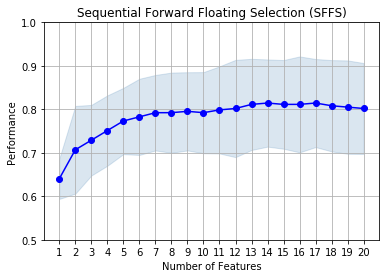

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271}
Tree


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished

[2018-04-02 20:09:53] Features: 1/20 -- score: 0.5959821428571429[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-04-02 20:09:53] Features: 2/20 -- score: 0.6535714285714287[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-04-02 20:09:54] Features: 3/20 -- score: 0.6816468253968253[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed

[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2018-04-02 20:10:09] Features: 19/20 -- score: 0.744890873015873[Parallel(n_jobs=-1)]: Done   5 out of  41 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.1s finished

[2018-04-02 20:10:10] Features: 20/20 -- score: 0.7321428571428571

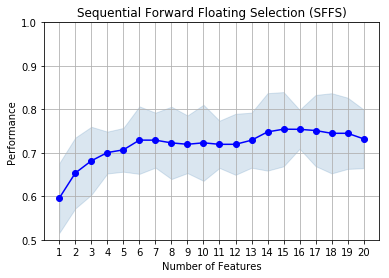

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762}
RandomForest


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.7s finished

[2018-04-02 20:10:19] Features: 1/20 -- score: 0.5869047619047619[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished

[2018-04-02 20:10:29] Features: 2/20 -- score: 0.615079365079365[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s finished

[2018-04-02 20:10:40] Features: 3/20 -- score: 0.6149305555555555[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished

[2018-04-02 20:10:50] Features: 4/20 -- score: 0.63769841

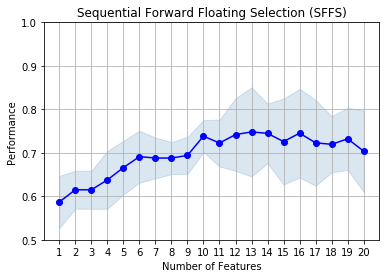

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762, 'RandomForest': 74.81150793650794}
QuadraticLDA


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished

[2018-04-02 20:13:57] Features: 1/20 -- score: 0.6310019841269842[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-04-02 20:13:58] Features: 2/20 -- score: 0.7101686507936508[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-04-02 20:13:59] Features: 3/20 -- score: 0.7321924603174603[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed

[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.0s finished

[2018-04-02 20:14:12] Features: 14/20 -- score: 0.754563492063492[Parallel(n_jobs=-1)]: Done   7 out of  46 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2018-04-02 20:14:13] Features: 15/20 -- score: 0.7671626984126985[Parallel(n_jobs=-1)]: Done   7 out of  45 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished

[2018-04-02 20:14:13] Features: 16/20 -- score: 0.7607638888888889[Parallel(n_jobs=-1)]: Done   6 out of  

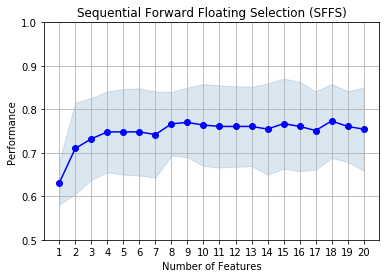

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762, 'RandomForest': 74.81150793650794, 'QuadraticLDA': 77.32142857142857}
NaiveBayes


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished

[2018-04-02 20:14:18] Features: 1/20 -- score: 0.6310019841269842[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-04-02 20:14:19] Features: 2/20 -- score: 0.678670634920635[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2018-04-02 20:14:20] Features: 3/20 -- score: 0.6941468253968254[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:

[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.0s finished

[2018-04-02 20:14:32] Features: 12/20 -- score: 0.7889384920634921[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2018-04-02 20:14:32] Features: 13/20 -- score: 0.7984623015873016[Parallel(n_jobs=-1)]: Done   8 out of  47 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Do

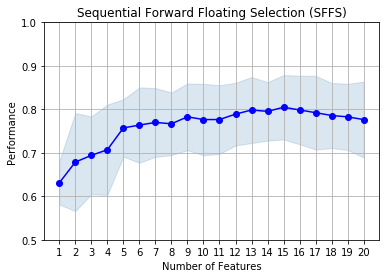

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762, 'RandomForest': 74.81150793650794, 'QuadraticLDA': 77.32142857142857, 'NaiveBayes': 80.48115079365078}
KNN


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished

[2018-04-02 20:14:40] Features: 1/20 -- score: 0.5898313492063492[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-04-02 20:14:40] Features: 2/20 -- score: 0.6026289682539682[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-04-02 20:14:41] Features: 3/20 -- score: 0.6721230158730159[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed

[2018-04-02 20:14:54] Features: 18/20 -- score: 0.7736607142857143[Parallel(n_jobs=-1)]: Done   5 out of  42 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2018-04-02 20:14:54] Features: 19/20 -- score: 0.7611111111111111[Parallel(n_jobs=-1)]: Done   5 out of  41 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs

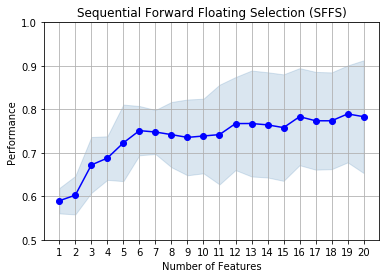

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762, 'RandomForest': 74.81150793650794, 'QuadraticLDA': 77.32142857142857, 'NaiveBayes': 80.48115079365078, 'KNN': 78.94345238095238}
ShrinkingLDA


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished

[2018-04-02 20:14:57] Features: 1/20 -- score: 0.6403769841269842[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-04-02 20:14:58] Features: 2/20 -- score: 0.7038194444444444[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-04-02 20:14:59] Features: 3/20 -- score: 0.7353174603174603[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed

[2018-04-02 20:15:13] Features: 17/20 -- score: 0.7890873015873016[Parallel(n_jobs=-1)]: Done   6 out of  43 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2018-04-02 20:15:14] Features: 17/20 -- score: 0.7921626984126984[Parallel(n_jobs=-1)]: Done   6 out of  43 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2018-04-02 20:15:14] Features: 18/20 -- score: 0.7890376984126984[Parallel(n_jobs=-1)]: Done   5 out of  

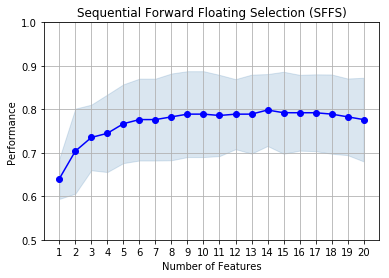

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762, 'RandomForest': 74.81150793650794, 'QuadraticLDA': 77.32142857142857, 'NaiveBayes': 80.48115079365078, 'KNN': 78.94345238095238, 'ShrinkingLDA': 79.84126984126985}
MLP


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.9min finished

[2018-04-02 20:21:09] Features: 1/20 -- score: 0.6214285714285714[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  5.8min finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished

[2018-04-02 20:27:00] Features: 2/20 -- score: 0.6087301587301587[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:  5.4min finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.7s finished

[2018-04-02 20:32:35] Features: 3/20 -- score: 0.6279265873015873[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.9s finished

[2018-04-02 20:36:26] Features: 4/20 -- score: 0.6912202

[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:   11.1s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   16.4s finished

[2018-04-02 21:01:25] Features: 15/20 -- score: 0.7637896825396826[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   48.7s finished
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   12.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   17.2s finished

[2018-04-02 21:02:31] Features: 16/20 -- score: 0.7572916666666667[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   50.5s finished
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   14.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   16.9s finished

[2018-04-02 21:03:39] Features: 17/20 -- score: 0.767063492063492[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.0s
[Parallel(n_jobs

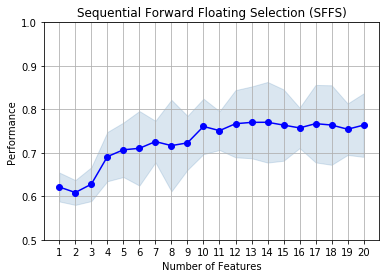

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762, 'RandomForest': 74.81150793650794, 'QuadraticLDA': 77.32142857142857, 'NaiveBayes': 80.48115079365078, 'KNN': 78.94345238095238, 'ShrinkingLDA': 79.84126984126985, 'MLP': 77.02380952380953}
SVM


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished

[2018-04-02 21:07:01] Features: 1/20 -- score: 0.6405257936507937[Parallel(n_jobs=-1)]: Done  14 out of  59 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2018-04-02 21:07:03] Features: 2/20 -- score: 0.6878968253968254[Parallel(n_jobs=-1)]: Done  13 out of  58 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished

[2018-04-02 21:07:04] Features: 3/20 -- score: 0.6913690476190476[Parallel(n_jobs=-1)]: Done  13 out of  57 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  57 out of  57

[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.3s finished

[2018-04-02 21:07:29] Features: 20/20 -- score: 0.8331349206349206

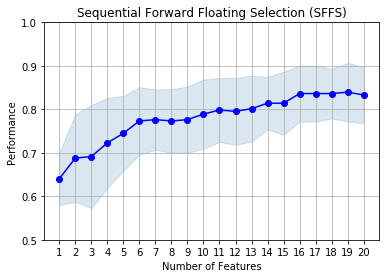

{'LDA': 80.48115079365078, 'LogisticRegression': 81.44841269841271, 'Tree': 75.43154761904762, 'RandomForest': 74.81150793650794, 'QuadraticLDA': 77.32142857142857, 'NaiveBayes': 80.48115079365078, 'KNN': 78.94345238095238, 'ShrinkingLDA': 79.84126984126985, 'MLP': 77.02380952380953, 'SVM': 83.9434523809524}


In [103]:
# models = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))

Results = []
classifiers = []
Accuracy=[]
Final_results = {}
for model in gumpy.classification.available_classifiers:
    print (model)
    feature_idx, cv_scores, algorithm,sfs = gumpy.features.sequential_feature_selector(features, labels, model,(6, 20), 5, 'SFFS')
    classifiers.append(model)
    Accuracy.append (cv_scores*100) 
    Final_results[model]= cv_scores*100
    print (Final_results)
   


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.1s finished

[2018-04-02 12:34:23] Features: 1/20 -- score: 0.6157334244702666[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2018-04-02 12:34:25] Features: 2/20 -- score: 0.6761663249031671[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished

[2018-04-02 12:34:26] Features: 3/20 -- score: 0.6994376851218956[Parallel(n_jobs=-1)]: Done  42 out of  57 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2018-04-02 12:34:28] Features: 4/20 -- score: 0.7074367737525632[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.0s finished
[Paral

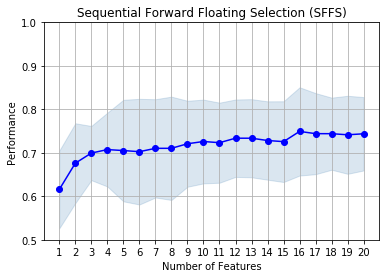

In [31]:
from sklearn.cross_validation import cross_val_score
feature_idx, cv_scores, algorithm,sfs = gumpy.features.sequential_feature_selector(features, labels, 'SVM',(6, 20), 5, 'SFFS')

features=features[:,feature_idx]
scores = cross_val_score(clf, features, labels, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [32]:
print (cv_scores*100)

74.92371838687627


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.4s finished

[2018-03-26 21:13:07] Features: 1/30 -- score: 0.8077188868042526[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished

[2018-03-26 21:13:09] Features: 2/30 -- score: 0.8949202626641652[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished

[2018-03-26 21:13:11] Features: 3/30 -- score: 0.9201125703564728[Parallel(n_jobs=-1)]: Done  42 out of  57 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2018-03-26 21:13:13] Features: 4/30 -- score: 0.9326156973108193[Parallel(n_job

[2018-03-26 21:13:59] Features: 19/30 -- score: 0.9576829268292684[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.6s finished

[2018-03-26 21:14:02] Features: 20/30 -- score: 0.9576829268292684[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[2018-03-26 21:14:04] Features: 21/30 -- score: 0.9551219512195122[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.7s finished

[2018-

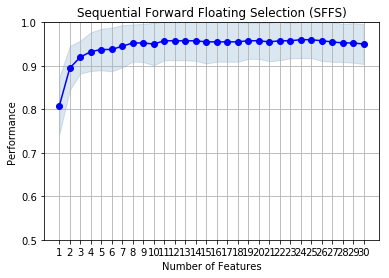

96.01219512195122


In [159]:
# from pandas import DataFrame
# import pandas as pd
# import xlsxwriter
# sheet_name = "subject"
# path_to_excel='/home/zied/Documents/B01.xlsx'
# writer     = pd.ExcelWriter(path_to_excel, engine='xlsxwriter')
# df = pd.DataFrame.from_records([Final_results]) 
# df.to_excel(writer, sheet_name=sheet_name,header=True)
if 1: 
    feature_idx, cv_scores, algorithm = gumpy.features.sequential_feature_selector(features, labels, 'SVM', (6, 30), 10, 'SFFS')
    path_to_feature='/home/zied/Documents/GRAZ/B04/features.npy'
    path_to_label='/home/zied/Documents/GRAZ/B04/labels.npy'
    features=features[:,feature_idx]
    np.save(path_to_feature,features)
    np.save(path_to_label,labels)
    features.shape

print (cv_scores*100)

## PCA 
``gumpy`` provides a wrapper around sklearn to reduce the dimensionality via PCA in a straightfoward manner.

In [143]:
PCA = gumpy.features.PCA_dim_red(features, 0.95)

## Splitting data for training
Now that we extracted features (and reduced the dimensionality), we can split the data for 
test and training purposes.

In [35]:
# gumpy exposes several methods to split a dataset, as shown in the examples:
if 0: 
    split_features = np.array(gumpy.split.normal(features, labels,test_size=0.2))
if 0: 
    n_splits=5
    split_features = np.array(gumpy.split.time_series_split(features, labels, n_splits)) 
if 0: 
    split_features = np.array(gumpy.split.normal(PCA, labels, test_size=0.2))
    
#ShuffleSplit: Random permutation cross-validator 
if 0: 
    split_features = gumpy.split.shuffle_Split(features, labels, n_splits=10,test_size=0.2,random_state=0)
    
# #Stratified K-Folds cross-validator
# #Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole   
if 1: 
    split_features = gumpy.split.stratified_KFold(features, labels, n_splits=3)
    
#Stratified ShuffleSplit cross-validator   
#Repeated random sub-sampling validation
if 1: 
    split_features = gumpy.split.stratified_shuffle_Split(features, labels, n_splits=10,test_size=0.3,random_state=0)


# the functions return a list with the data according to the following example
X_train = split_features[0]
X_test = split_features[1]
Y_train = split_features[2]
Y_test = split_features[3]
X_train.shape

KFold
TRAIN: [132 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 3

(279, 30)

In [ ]:
gcf.n_layer=10
import sys, os, os.path
sys.path.append('/home/zied/gcForest')

from GCForest import gcForest
gcf = gcForest(shape_1X=30, window=4, n_cascadeRF=10, tolerance=0.0, min_samples_mgs=1, min_samples_cascade=1)
gcf.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score
pred_X = gcf.predict(X_test)
print(pred_X)
accuracy = accuracy_score(y_true=Y_test, y_pred=pred_X)
print('gcForest accuracy : {}'.format(accuracy))


## Plotting features
``gumpy`` wraps 3D plotting of features into a single line

In [ ]:
gumpy.plot.PCA("3D", features, split_features[0], split_features[2])

## Classification without feature selection 

In [36]:
Results = []
classifiers = []
Accuracy=[]
Final_results = {}
for model in gumpy.classification.available_classifiers:
    results, clf = gumpy.classify(model, X_train, Y_train, X_test, Y_test)
    print (model)
    print (results)
    classifiers.append(model)
    Accuracy.append (results.accuracy) 
    Final_results[model]= results.accuracy
print (Final_results)

RandomForest
             precision    recall  f1-score   support

          0       0.87      0.92      0.89        60
          1       0.91      0.87      0.89        60

avg / total       0.89      0.89      0.89       120

KNN
             precision    recall  f1-score   support

          0       0.83      0.92      0.87        60
          1       0.91      0.82      0.86        60

avg / total       0.87      0.87      0.87       120

SVM
             precision    recall  f1-score   support

          0       0.84      0.98      0.91        60
          1       0.98      0.82      0.89        60

avg / total       0.91      0.90      0.90       120

NaiveBayes
             precision    recall  f1-score   support

          0       0.86      0.95      0.90        60
          1       0.94      0.85      0.89        60

avg / total       0.90      0.90      0.90       120

ShrinkingLDA
             precision    recall  f1-score   support

          0       0.83      1.00      0.9

In [38]:
from pandas import DataFrame
import pandas as pd
import xlsxwriter
sheet_name = subject
path_to_excel='/home/zied/Documents/second.xlsx'
writer     = pd.ExcelWriter(path_to_excel, engine='xlsxwriter')
df = pd.DataFrame.from_records([Final_results]) 
df.to_excel(writer, sheet_name=sheet_name,header=True)
if 0: 
    path_to_feature=''
    path_to_label=''
    features=features[:,feature_idx]
    np.save(path_to_feature,features)
    np.save(path_to_label,labels)
    features.shape
# print("Classification results on test set:")
# print(results)
# print("Accuracy: ", results.accuracy)

## Confusion Matrix
One of the ideas behind ``gumpy`` is to provide users the means to quickly examine their data. Therefore, gumpy provides mostly wraps existing libraries. This allows to show data with ease, and still be able to modify the plots in any way the underlying libraries allow:

In [ ]:
gumpy.plot.confusion_matrix(Y_test, results.pred)

## Voting Classifier with feature selection
`gumpy` allows to automatically use all classifiers that are known in `gumpy.classification.available_classifiers` in a voting classifier (for more details see `sklearn.ensemble.VotingClassifier`). In case you developed a custom classifier and registered it using the `@register_classifier` decorator, it will be automatically used as well.

In [ ]:
result, _ = gumpy.classification.vote(X_train, Y_train, X_test, Y_test, 'soft', False, (6,12))
print("Classification result for hard voting classifier")
print(result)
print("Accuracy: ", result.accuracy)

Again, we can plot the confusion matrix to have a look at the results

In [ ]:
gumpy.plot.confusion_matrix(result.pred, Y_test)

Because `gumpy.classification.vote` uses `sklearn.ensemble.VotingClassifier` as backend, it is possible to specify different methods for the voting such as 'soft'. In addition, the method can be told to first extract features via `mlxtend.feature_selection.SequentialFeatureSelector` before classification.

In [ ]:
result, _ = gumpy.classification.vote(X_train, Y_train, X_test, Y_test, 'soft', True, (6,12))
print("Classification result for soft voting classifier")
print(result)
print("Accuracy: ", result.accuracy)

In [ ]:
gumpy.plot.confusion_matrix(result.pred, Y_test)